# Notebook 1 - exploratory data analysis and data cleaning

### The data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 25 columns):
id        600000 non-null int64
bin_0     582106 non-null float64
bin_1     581997 non-null float64
bin_2     582070 non-null float64
bin_3     581986 non-null object
bin_4     581953 non-null object
nom_0     581748 non-null object
nom_1     581844 non-null object
nom_2     581965 non-null object
nom_3     581879 non-null object
nom_4     581965 non-null object
nom_5     582222 non-null object
nom_6     581869 non-null object
nom_7     581997 non-null object
nom_8     582245 non-null object
nom_9     581927 non-null object
ord_0     581712 non-null float64
ord_1     581959 non-null object
ord_2     581925 non-null object
ord_3     582084 non-null object
ord_4     582070 non-null object
ord_5     582287 non-null object
day       582048 non-null float64
month     582012 non-null float64
target    600000 non-null int64
dtypes: float64(6), int64(2), object(17)
memory usage: 114.4

In [3]:
test = pd.read_csv('data/test.csv')
print(set(train.columns)-set(['target']) == set(test.columns)) # sanity check
test.info()

True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 24 columns):
id       400000 non-null int64
bin_0    388099 non-null float64
bin_1    387962 non-null float64
bin_2    388028 non-null float64
bin_3    388049 non-null object
bin_4    388049 non-null object
nom_0    387938 non-null object
nom_1    388053 non-null object
nom_2    387821 non-null object
nom_3    387824 non-null object
nom_4    388007 non-null object
nom_5    388088 non-null object
nom_6    387988 non-null object
nom_7    387997 non-null object
nom_8    388044 non-null object
nom_9    387940 non-null object
ord_0    388107 non-null float64
ord_1    387833 non-null object
ord_2    387895 non-null object
ord_3    387947 non-null object
ord_4    388067 non-null object
ord_5    387953 non-null object
day      387975 non-null float64
month    388016 non-null float64
dtypes: float64(6), int64(1), object(17)
memory usage: 73.2+ MB


Every feature has roughly 3% values missing. Feature type is already given (presuming that the column names are accurate), which simplifies things a lot. 

In [4]:
print(1-len(train.dropna())/len(train))
print(1-len(test.dropna())/len(test))

0.5032633333333334
0.504595


Half of all rows contain some missing value, therefore dropping all rows with missing values is not smart. We need to figure out a way to encode missing values. As we explore features, we need to keep in mind that we are predicting a binary value and we are optimizing the ROC AUC of our prediction. This means we can treat the task as a regression task in [0,1] as well as a classification task, since we want to output confidence levels rather than a binary class. It also means that the learning algorithms we might want to try are nearest neighbours regression, logistic regression, multinomial naive Bayes classification and of course tree-based ensembles like random forest and gradient boosted trees. 

In [5]:
train.head(10)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0
5,5,0.0,NaN,1.0,T,N,Red,Triangle,Lion,China,...,05afc0f8b,2.0,Expert,Hot,b,Q,wa,3.0,4.0,0
6,6,0.0,0.0,0.0,F,N,Red,Triangle,Hamster,Costa Rica,...,4d3766412,1.0,Grandmaster,Cold,c,R,rg,5.0,6.0,0
7,7,0.0,0.0,1.0,T,N,Red,Triangle,Axolotl,Finland,...,a651dec43,3.0,Expert,Cold,b,Y,PS,1.0,1.0,0
8,8,0.0,0.0,0.0,F,N,Blue,Polygon,Hamster,Russia,...,NaN,1.0,Novice,Boiling Hot,c,N,mX,6.0,3.0,0
9,9,0.0,0.0,NaN,F,Y,Red,Polygon,Hamster,Finland,...,79b29d54c,3.0,Contributor,Lava Hot,n,I,OZ,1.0,8.0,1


### The columns

```'id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'```

In [6]:
for i in range(0, 5):
    print(i)
    print(train['bin_{}'.format(i)].value_counts(dropna=False))
    print()

0
 0.0    528377
 1.0     53729
NaN      17894
Name: bin_0, dtype: int64

1
 0.0    474018
 1.0    107979
NaN      18003
Name: bin_1, dtype: int64

2
 0.0    419845
 1.0    162225
NaN      17930
Name: bin_2, dtype: int64

3
F      366212
T      215774
NaN     18014
Name: bin_3, dtype: int64

4
N      312344
Y      269609
NaN     18047
Name: bin_4, dtype: int64



0,1,2 - Clear and simple binary value, though unbalanced. NA-s could be replaced with the much more common value 0 or imputed. A feature signifying whether the value was missing would also be good.

3,4 - Fairly balanced string-encoded binary value. NA-s could be replaced with a random value or imputed based on nearest neighbours. A feature signifying whether the value was missing would also be good.

In [7]:
train['bin_3'] = train['bin_3'].map({'F': 0, 'T': 1})
train['bin_4'] = train['bin_4'].map({'N': 0, 'Y': 1})

test['bin_3'] = test['bin_3'].map({'F': 0, 'T': 1})
test['bin_4'] = test['bin_4'].map({'N': 0, 'Y': 1})

In [8]:
for i in range(0, 6):
    print(i)
    if i == 5:
        print(train['ord_{}'.format(i)].value_counts(dropna=False)[:5])
        print(train['ord_{}'.format(i)].value_counts(dropna=False)[-5:])
        print(sorted(train['ord_{}'.format(i)].dropna().unique()))
    else:
        print(train['ord_{}'.format(i)].value_counts(dropna=False))
    print()

0
 1.0    227917
 3.0    197798
 2.0    155997
NaN      18288
Name: ord_0, dtype: int64

1
Novice         160597
Expert         139677
Contributor    109821
Grandmaster     95866
Master          75998
NaN             18041
Name: ord_1, dtype: int64

2
Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
NaN             18075
Name: ord_2, dtype: int64

3
n      70982
a      65321
m      57980
c      56675
h      55744
o      45464
b      44795
e      38904
k      38718
i      34763
d      30634
f      29450
NaN    17916
g       6180
j       3639
l       2835
Name: ord_3, dtype: int64

4
N      39978
P      37890
Y      36657
A      36633
R      33045
U      32897
M      32504
X      32347
C      32112
H      31189
Q      30145
T      29723
O      25610
B      25212
E      21871
K      21676
I      19805
NaN    17930
D      17284
F      16721
W       8268
Z       5790
S       4595
G       3404
V       3107
J  

0 - Clear

1,2,3,4 - Need to be ordered

5 - could be ordered alphabetically

NA 0, marking column useful

In [9]:
def alpha1(x):
    return '_abcdefghijklmnopqrstuvwxyz'.index(x)

def alpha2(x):
    return '_ABCDEFGHIJKLMNOPQRSTUVWXYZ'.index(x)

order = sorted(train['ord_5'].dropna().unique())
def alpha3(x):
    return order.index(x)+1

train['ord_1'] = train['ord_1'].map({'Novice': 1, 'Contributor': 2, 'Expert': 3, 'Master': 4, 'Grandmaster': 5})
train['ord_2'] = train['ord_2'].map({'Freezing': 1, 'Cold': 2, 'Warm': 3,'Hot': 4, 'Boiling Hot': 5, 'Lava Hot': 6})
train['ord_3'] = train['ord_3'].map(alpha1, na_action='ignore')
train['ord_4'] = train['ord_4'].map(alpha2, na_action='ignore')
train['ord_5'] = train['ord_5'].map(alpha3, na_action='ignore')

test['ord_1'] = test['ord_1'].map({'Novice': 1, 'Contributor': 2, 'Expert': 3, 'Master': 4, 'Grandmaster': 5})
test['ord_2'] = test['ord_2'].map({'Freezing': 1, 'Cold': 2, 'Warm': 3,'Hot': 4, 'Boiling Hot': 5, 'Lava Hot': 6})
test['ord_3'] = test['ord_3'].map(alpha1, na_action='ignore')
test['ord_4'] = test['ord_4'].map(alpha2, na_action='ignore')
test['ord_5'] = test['ord_5'].map(alpha3, na_action='ignore')

In [10]:
for i in range(0, 10):
    print(i)
    if i >= 5:
        print(len(train['nom_{}'.format(i)].dropna().unique()), 'unique values')
        print(train['nom_{}'.format(i)].value_counts(dropna=False)[:5])
        print(train['nom_{}'.format(i)].value_counts(dropna=False)[-5:])
    else:
        print(train['nom_{}'.format(i)].value_counts(dropna=False))
    print()

0
Red      323286
Blue     205861
Green     52601
NaN       18252
Name: nom_0, dtype: int64

1
Triangle     164190
Polygon      152563
Trapezoid    119438
Circle       104995
Square        26503
NaN           18156
Star          14155
Name: nom_1, dtype: int64

2
Hamster    164897
Axolotl    152319
Lion       119504
Dog        104825
Cat         26276
NaN         18035
Snake       14144
Name: nom_2, dtype: int64

3
India         164869
Costa Rica    151827
Russia        119840
Finland       104601
Canada         26425
NaN            18121
China          14317
Name: nom_3, dtype: int64

4
Theremin    308621
Bassoon     196639
Oboe         49996
Piano        26709
NaN          18035
Name: nom_4, dtype: int64

5
1220 unique values
NaN          17778
fc8fc7e56      977
360a16627      972
423976253      961
7917d446c      961
Name: nom_5, dtype: int64
7335087fd    5
30019ce8a    3
b3ad70fcb    1
d6bb2181a    1
0385d0739    1
Name: nom_5, dtype: int64

6
1519 unique values
NaN          18131

0 - simple categorical, one-hot encoding with NaN being own column or all zeroes

1 - some order might come from number of angles if we ignore "polygon", but let's trust the labeling that it is simple categorical

2,3,4 - simple categorical, but grouping features possible by some logic, countries could have latitude and longitude

5,6,7,8,9 - obvious hex but not obvious how to decode, could be made into lower cardinality with ranking bins or top rankers and "others"

 3.0    113835
 5.0    110464
 6.0     97432
 7.0     86435
 1.0     84724
 2.0     65495
 4.0     23663
NaN      17952
Name: day, dtype: int64


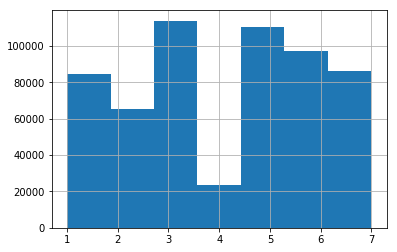

 8.0     79245
 3.0     70160
 5.0     68906
 12.0    68340
 6.0     60478
 7.0     53480
 1.0     52154
 11.0    51165
 2.0     40700
 9.0     20620
NaN      17988
 4.0     14614
 10.0     2150
Name: month, dtype: int64


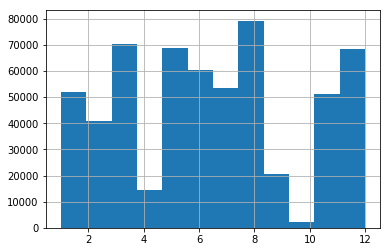

In [11]:
print(train['day'].value_counts(dropna=False))
train['day'].hist(bins=7)
plt.show()
print(train['month'].value_counts(dropna=False))
train['month'].hist(bins=12)

These are ordinal features, but could use some cyclical encodings. Some curiously low values.

In [12]:
train['target'].value_counts()

0    487677
1    112323
Name: target, dtype: int64

Target is imbalanced, consider using different sampling methods

ord_0


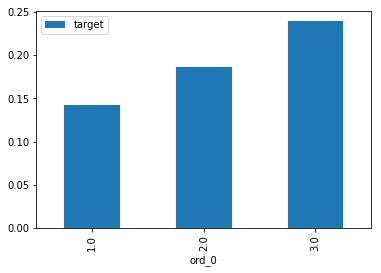

ord_1


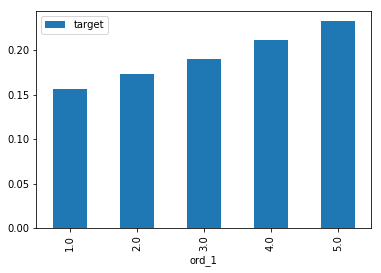

ord_2


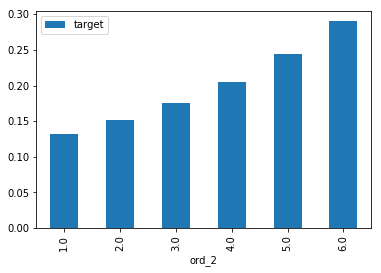

ord_3


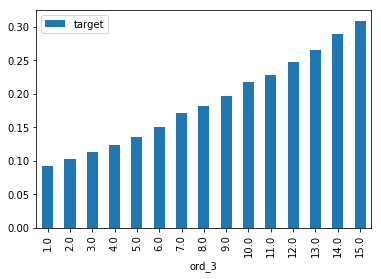

ord_4


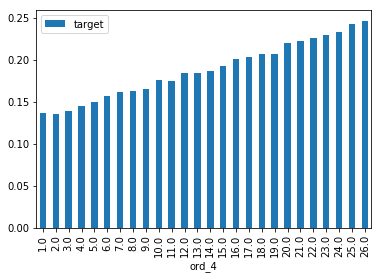

day


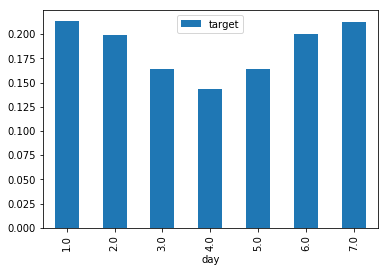

month


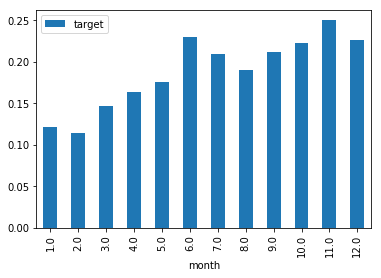

In [13]:
for col in ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'day', 'month']:
    print(col)
    train[[col, 'target']].groupby(col).mean().plot.bar()
    plt.show()

Mean target across all ordinal values shows visible trends, day has cyclic trend

In [14]:
for col in test.columns:
    print(col)
    print(test[col].value_counts())

id
600027    1
879352    1
899810    1
897763    1
887524    1
885477    1
891622    1
889575    1
912104    1
910057    1
916202    1
914155    1
903916    1
901869    1
908014    1
905967    1
862960    1
860913    1
867058    1
865011    1
854772    1
852725    1
858870    1
893665    1
895712    1
807647    1
799443    1
850634    1
848587    1
838348    1
         ..
658923    1
669164    1
671213    1
665070    1
667119    1
757211    1
761305    1
740803    1
736717    1
751044    1
753093    1
746950    1
748999    1
726472    1
728521    1
722378    1
724427    1
734668    1
730574    1
759256    1
732623    1
775632    1
777681    1
771538    1
773587    1
783828    1
785877    1
779734    1
781783    1
600101    1
Name: id, Length: 400000, dtype: int64
bin_0
0.0    351777
1.0     36322
Name: bin_0, dtype: int64
bin_1
0.0    315353
1.0     72609
Name: bin_1, dtype: int64
bin_2
0.0    279998
1.0    108030
Name: bin_2, dtype: int64
bin_3
0.0    244092
1.0    143957
Name: bin_3,

In [15]:
train.to_csv('data/cleaned_train.csv', index=False)
test.to_csv('data/cleaned_test.csv', index=False)